Draw


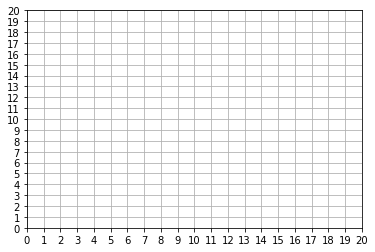

Instructions for updating:
Use `tf.global_variables_initializer` instead.
5000
Loss: 26.0063
Epsilon: 0.985260820207
10000
Loss: 8.47574
Epsilon: 0.970741078213
15000
Loss: 5.58463
Epsilon: 0.956437507015
20000
Loss: 2.54813
Epsilon: 0.942346888248
25000
Loss: 0.610778
Epsilon: 0.928466051465
30000
Loss: 0.43834
Epsilon: 0.914791873419
35000
Loss: 0.0102898
Epsilon: 0.90132127736
40000
Loss: 0.254961
Epsilon: 0.88805123235
45000
Loss: 0.00123056
Epsilon: 0.874978752571
50000
Loss: 0.00286637
Epsilon: 0.862100896661
55000
Loss: 0.000682194
Epsilon: 0.849414767047
60000
Loss: 0.995006
Epsilon: 0.836917509297
65000
Loss: 0.00187536
Epsilon: 0.824606311475
70000
Loss: 0.000307594
Epsilon: 0.81247840351
75000
Loss: 0.000284887
Epsilon: 0.800531056572
75000
Loss: 0.0317317
Epsilon: 0.800531056572
75000
Loss: 0.0059803
Epsilon: 0.800531056572
80000
Loss: 0.000125016
Epsilon: 0.788761582456
85000
Loss: 1.12926e-06
Epsilon: 0.777167332981
90000
Loss: 0.000552224
Epsilon: 0.765745699393
95000
Lo

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
class Q_Network:
    N_Mesh=20
    State_Number=N_Mesh*N_Mesh;
    Action_Number=4;
    Action_List=np.identity(Action_Number)
    State_List=np.identity(State_Number)
    Epsilon=0
    Epsilon_Begin=1
    Epsilon_Final=0.01
    decay_rate=0.000003
    Step=0
    Batch_Number=20
    #Explore = 100000.
    Observe=1000#The number of steps of observation before the beginning of the training
    Store_Memory = deque()
    Cost_History=[]
    Memory_Size = 5000
    #Obstacle=np.random.randint(N_Mesh,State_Number-2,size=100)
    #Obstacle=[20,3,5,16,21,23,27,29,31,33,34,56,57,66,67,78,81,86]
    Obstacle=[]
    Play_Done=None
    def __init__(self,Learning_Rate=0.001,Gamma=0.9,Memory_Size=5000):
        self.Learning_Rate=Learning_Rate
        self.Gamma=Gamma
        self.Memory_Size=Memory_Size
        self.Draw_Obstacle()
        self.New_Network()
        self.session=tf.InteractiveSession()
        self.session.run(tf.initialize_all_variables())
     #***************************************************************
    def New_Network(self):
         #Construct a neural network
        self.State_Input=tf.placeholder(tf.float32,[None,self.State_Number])#Input_Number=100, M=Batch*100
        self.Action_Input=tf.placeholder(tf.float32,[None,self.Action_Number])#Input_Number=4, M=Batch*4
        self.Q_Target_OI=tf.placeholder(dtype=tf.float32,shape=[None])
        #Layer1
        Layer1_Number=100
        w1=tf.Variable(tf.random_normal([self.State_Number,Layer1_Number]))
        b1=tf.Variable(tf.zeros([1,Layer1_Number])+0.1)
        l1=tf.nn.relu(tf.matmul(self.State_Input,w1)+b1) #b1 use the propagation mechanism
#         #Layer2
#         Layer2_Number=10
#         w2=tf.Variable(tf.random_normal([Layer1_Number,Layer2_Number]))
#         b2=tf.Variable(tf.zeros([1,Layer2_Number]))
#         l2=tf.nn.relu(tf.matmul(l1,w2)+b2)
        #Layer3
        Layer3_Number=self.Action_Number
        w3=tf.Variable(tf.random_normal([Layer1_Number,Layer3_Number]))
        b3=tf.Variable(tf.zeros([1,Layer3_Number]))
        self.l3=tf.matmul(l1,w3)+b3#At this time, not yet use the active action, l3 is the output matrice, M=Batch*4
        #self.l3=tf.tanh(tf.matmul(l1,w2)+b2)

        self.Q_Value=tf.reduce_sum(tf.multiply(self.l3,self.Action_Input),reduction_indices=1)
        self.Loss=tf.reduce_mean(tf.square(self.Q_Value-self.Q_Target_OI))
        #self.Loss=tf.reduce_mean(tf.square(self.Q_Value-tf.tanh(self.Q_Target_OI)))
        self.Optimizer=tf.train.GradientDescentOptimizer(self.Learning_Rate).minimize(self.Loss)
        #Network's Output is like this form [19,20,297,30], argmax is 2, then choose Action2  
        self.Predict=tf.argmax(self.l3,1)
     #***************************************************************
    def Select_Action(self,State_Index):
        Current_State=self.State_List[State_Index:State_Index+1] #By example, Action_Index is 2, Current_State=[0,0,1,0， ，]
        if np.random.uniform()<self.Epsilon:
            Choose_Action_Index=np.random.randint(0,self.Action_Number)
        else:
            Action_QValue_Output=self.session.run(self.l3,feed_dict={self.State_Input:Current_State})
            Choose_Action_Index=np.argmax(Action_QValue_Output)
        #The first inegality means the train has beginned
        #The second inegality means Epsilon has not yet decreased to final value
        self.Epsilon=self.Epsilon_Final+(self.Epsilon_Begin-self.Epsilon_Final)*np.exp(-self.decay_rate*self.Step)
#         if(self.Step%1000==0):
#             print("epsilon ",self.Epsilon)
        return Choose_Action_Index
     #***************************************************************
    def Next_State(self,Action_Index,State_Index):
        State=State_Index+1
        done=False
        #Execute left motion
        if(Action_Index==0):
            if(State%self.N_Mesh==1):
                State=State
                R=-1000
            elif((State+1) in self.Obstacle):#When encounter obstables, we stay 
                State=State
                R=-1000
            else:
                State=State-1
                R=0
        elif(Action_Index==1):
            if(State==self.State_Number-1):
                State=State+1
                done=True
                R=100
            elif(State%self.N_Mesh==0):
                State=State
                R=-100
            elif((State+1) in self.Obstacle):
                State=State
                R=-100
            else:
                State=State+1
                R=0.1
        elif(Action_Index==2):
            if(State==self.State_Number-self.N_Mesh):
                State=State+self.N_Mesh
                done=True
                R=100
            elif(self.State_Number+1-self.N_Mesh<=State<=self.State_Number-1):
                State=State
                R=-100
            elif((State+self.N_Mesh) in self.Obstacle):
                State=State+self.N_Mesh
                R=-100
            else:
                State=State+self.N_Mesh
                R=0.1
        else:
            if(0<=State<=self.N_Mesh):
                State=State
                R=-100
            elif((State-self.N_Mesh) in self.Obstacle):
                State=State-self.N_Mesh
                R=-100
            else:
                R=0
                State=State-self.N_Mesh
        return State-1,R,done
    
    def Save_Memory(self,CURRENT_STATET,CHOOSE_ACTION,NEXT_STATE,REWARD,DONE):
        Memory_Current_State=self.State_List[CURRENT_STATET:CURRENT_STATET+1]
        Memory_Choose_Action=self.Action_List[CHOOSE_ACTION:CHOOSE_ACTION+1]
        Memory_Next_State=self.State_List[NEXT_STATE:NEXT_STATE+1]
        self.Store_Memory.append((Memory_Current_State,Memory_Choose_Action,Memory_Next_State,REWARD,DONE))
        if len(self.Store_Memory)>self.Memory_Size:
            self.Store_Memory.popleft()
    
     #***************************************************************
    def Experience_Replay(self):
        Batch=self.Batch_Number
        MiniBatch=random.sample(self.Store_Memory,Batch)
        Batch_Current_State = None
        Batch_Execute_Action = None
        Batch_Reward = None
        Batch_Next_State = None
        Batch_Done = None
        
        for Index in range(Batch):
            if Batch_Current_State is None:
                Batch_Current_State=MiniBatch[Index][0]
            elif Batch_Current_State is not None:
                Batch_Current_State=np.vstack((Batch_Current_State, MiniBatch[Index][0]))
            #---------------------------------------------------------------------------------------   
            #print("BEA",MiniBatch[Index][1].shape)
            if Batch_Execute_Action is None:
                Batch_Execute_Action=MiniBatch[Index][1]
            elif Batch_Execute_Action is not None:
                Batch_Execute_Action=np.vstack((Batch_Execute_Action,MiniBatch[Index][1]))
           #---------------------------------------------------------------------------------------           
            if Batch_Reward is None:
                Batch_Reward=MiniBatch[Index][3]
            elif Batch_Reward is not None:
                Batch_Reward=np.vstack((Batch_Reward,MiniBatch[Index][3]))
            #---------------------------------------------------------------------------------------  
            if Batch_Next_State is None:
                Batch_Next_State=MiniBatch[Index][2]
            elif Batch_Next_State is not None:
                Batch_Next_State=np.vstack((Batch_Next_State,MiniBatch[Index][2]))
            #---------------------------------------------------------------------------------------      
            if Batch_Done is None:
                Batch_Done=MiniBatch[Index][4]
            elif Batch_Done is not None:
                Batch_Done=np.vstack((Batch_Done,MiniBatch[Index][4]))
            #Calculate the Q Value of the next State 
        Q_Next=self.session.run(self.l3,feed_dict={self.State_Input:Batch_Next_State})
        Q_Target=[]
        for i in range(Batch):
            Each_Reward=Batch_Reward[i][0]#This is a 2D array because of the vstack
            #Calculate the Target-Q-Value of each element in the Batch
            Each_QValue=Each_Reward+self.Gamma*np.max(Q_Next[i]) #The network ouput has its own []
            if Each_Reward<0:
                Q_Target.append(Each_Reward)
            else:
                Q_Target.append(Each_QValue)
        #print(self.session.run(self.Q_Value,feed_dict={self.Q_Target_OI:Q_Target}))
        _,Cost,Rew=self.session.run([self.Q_Value,self.Loss,self.Optimizer],feed_dict={self.State_Input:Batch_Current_State,
                                                                                        self.Action_Input:Batch_Execute_Action,
                                                                                        self.Q_Target_OI: Q_Target})
        self.Cost_History.append(Cost)
        if self.Step%5000==0:
            print(self.Step)  
            print("Loss:", Cost)  
            print("Epsilon:", self.Epsilon)   
    #**************************************************************
    def Train(self):
        while True:
            Train_Current_State=np.random.randint(0,self.State_Number-1)
            if((Train_Current_State in self.Obstacle)is not True):
                break
        self.Epsilon = self.Epsilon_Begin
        while True:
            Train_Action=self.Select_Action(Train_Current_State)
            #print("TA",Train_Action)
            Train_Next_State,Train_Reward,Train_Done=self.Next_State(Train_Action,Train_Current_State)
            self.Save_Memory(Train_Current_State,Train_Action,Train_Next_State,Train_Reward,Train_Done)
            if self.Step>self.Observe:
                self.Experience_Replay()
            if self.Step>200000:
                 break;
            if Train_Done:
                while True:
                    if((Train_Current_State in self.Obstacle)is not True):
                        break
            else:
                Train_Current_State=Train_Next_State
                self.Step+=1          
    #***************************************************************
    def Play(self):
        self.Train()
        Start_Room_Index=0;
        Play_Current_State_Index=0
        Play_Step=0;
        print("****************** Agent is in the State",Start_Room_Index,"**********************")
        while(Play_Current_State_Index!=self.State_Number-1):
            Play_Current_State=self.State_List[Play_Current_State_Index:Play_Current_State_Index+1]
            Play_Action=(self.session.run(self.Predict,feed_dict={self.State_Input:Play_Current_State}))
            if Play_Action==0:
                Play_Current_State_Index=Play_Current_State_Index-1
            elif Play_Action==1:
                Play_Current_State_Index=Play_Current_State_Index+1
            elif Play_Action==2:
                Play_Current_State_Index=Play_Current_State_Index+self.N_Mesh
            else:
                Play_Current_State_Index=Play_Current_State_Index-self.N_Mesh
            Play_Step+=1
            print("Step is ",Play_Step,"****************** Agent is in the State", Play_Current_State_Index,"**********************")
            if(Play_Step>100):
                break
        if Play_Current_State_Index==self.State_Number-1:
            self.Graph()
    #***************************************************************        
    def Caculate_coordinate(self,State):
        X_Axis=0.5+(State-1)%self.N_Mesh
        Y_Axis=0.5+((State-1)//self.N_Mesh)
        return X_Axis,Y_Axis 
    #***************************************************************  
    def Graph(self): 
        Graph_Step=0
        fig=plt.figure()
        ax=fig.gca()
        ax.set(xlim=[0, self.N_Mesh], ylim=[0, self.N_Mesh])
        ax.set_xticks(np.arange(0,(self.N_Mesh+1)))
        ax.set_yticks(np.arange(0,(self.N_Mesh+1)))
        plt.grid()
        Graph_Start_Index=0
        Graph_Current_Index=Graph_Start_Index
        while(Graph_Current_Index!=self.State_Number-1):
            Graph_Current_State=self.State_List[Graph_Current_Index:Graph_Current_Index+1]
            Graph_Action=(self.session.run(self.Predict,feed_dict={self.State_Input:Graph_Current_State}))
            if(Graph_Action==0):
                Graph_Next_Index=Graph_Current_Index-1
            elif(Graph_Action==1):
                Graph_Next_Index=Graph_Current_Index+1
            elif(Graph_Action==2):
                 Graph_Next_Index=Graph_Current_Index+self.N_Mesh
            else:
                 Graph_Next_Index=Graph_Current_Index-self.N_Mesh
            Graph_Step+=1
            X_State,Y_State=self.Caculate_coordinate(Graph_Current_Index+1)
            X_Next_State,Y_Next_State=self.Caculate_coordinate(Graph_Next_Index+1)
            if(Graph_Step==0):
                plt.scatter(X_State,Y_State)  
            else:
                plt.scatter(X_State,Y_State) 
                plt.scatter(X_Next_State,Y_Next_State)
                plt.plot([X_State,X_Next_State],[Y_State,Y_Next_State])
            for J in np.arange(len(self.Obstacle)):
                plt.scatter((self.Caculate_coordinate(self.Obstacle[J]+1))[0],(self.Caculate_coordinate(self.Obstacle[J]+1))[1],marker="x")
            Graph_Current_Index=Graph_Next_Index
    plt.show()
    def Draw_Obstacle(self):
        print('Draw')
        fig=plt.figure()
        ax=fig.gca()
        ax.set(xlim=[0, self.N_Mesh], ylim=[0, self.N_Mesh])
        ax.set_xticks(np.arange(0,(self.N_Mesh+1)))
        ax.set_yticks(np.arange(0,(self.N_Mesh+1)))
        plt.grid()
        for J in np.arange(len(self.Obstacle)):
                plt.scatter((self.Caculate_coordinate(self.Obstacle[J]+1))[0],(self.Caculate_coordinate(self.Obstacle[J]+1))[1],marker="x")
        plt.show()
if __name__ == "__main__":
    q_network = Q_Network()
    q_network.Play()
    
    

In [2]:
import numpy as np
H=np.arange(20).reshape(4,5)
print(H)
D=np.argmax(H,axis=1)
print(D)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]
[4 4 4 4]
